In [13]:
import pandas as pd
import joblib
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize

 Chargement du fichier...
✅ Fichier chargé ! 8011296 lignes, 12 colonnes
✅ Colonne 'user_id' supprimée !
✅ 0 valeurs NaN restantes
 Conversion de 'last_event_time' en timestamp...
✅ 'last_event_time' converti en timestamp !
 X shape: (7694048, 10), y shape: (7694048,)
 Échantillonnage aléatoire de 500000 lignes...
✅ Échantillonnage effectué !
⚖️ Application de SMOTE pour équilibrer les classes...
✅ Dataset équilibré : 1859736 lignes
✅ Jeu d'entraînement et de test créés !
⚙️ Création du pipeline...
✅ Pipeline prêt !
 Entraînement du modèle...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1866
[LightGBM] [Info] Number of data points in the train set: 1487788, number of used features: 10
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from scor

c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Accuracy : 0.9993
 Rapport de classification :
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     92987
         1.0       1.00      1.00      1.00     92987
         2.0       1.00      1.00      1.00     92987
         3.0       1.00      1.00      1.00     92987

    accuracy                           1.00    371948
   macro avg       1.00      1.00      1.00    371948
weighted avg       1.00      1.00      1.00    371948



c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC macro : 1.0000
 Matrice de confusion :
 [[92867    79    41     0]
 [   17 92970     0     0]
 [   38     0 92878    71]
 [    0     0     7 92980]]


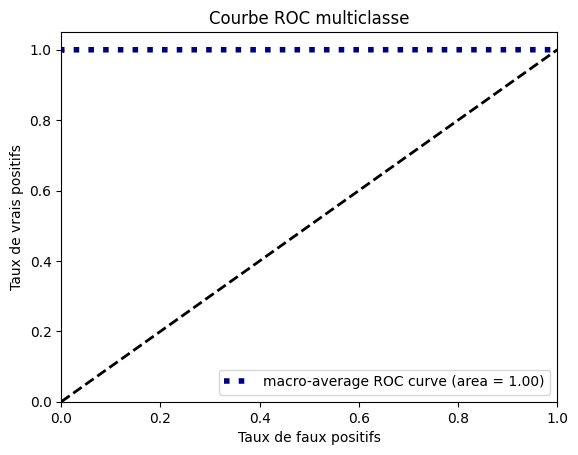

✅ Modèle enregistré avec succès à ../data/output/cluster_classifier.pkl ! 
⏳ Temps total d'exécution : 9.75 secondes


In [5]:
# ⏳ Début du script
start_time = time.time()

#  Charger les données
file_path = "../data/output/user_clusters.parquet"
print(" Chargement du fichier...")
df = pd.read_parquet(file_path)
print(f"✅ Fichier chargé ! {df.shape[0]} lignes, {df.shape[1]} colonnes")

#  Supprimer les colonnes inutiles (user_id si présent)
if "user_id" in df.columns:
    df.drop(columns=["user_id"], inplace=True)
    print("✅ Colonne 'user_id' supprimée !")

#  Supprimer les lignes avec des NaN dans 'Cluster'
df.dropna(subset=["Cluster"], inplace=True)
print(f"✅ {df.isna().sum().sum()} valeurs NaN restantes")

#  Conversion de 'last_event_time' en timestamp
print(" Conversion de 'last_event_time' en timestamp...")
df['last_event_time'] = pd.to_datetime(df['last_event_time']).astype(int) / 10**9
print("✅ 'last_event_time' converti en timestamp !")

#  Séparation des features et du target
y = df["Cluster"]
X = df.drop(columns=["Cluster"])
print(f" X shape: {X.shape}, y shape: {y.shape}")

# ️ Échantillonnage avant SMOTE (optionnel si dataset très grand)
SAMPLE_SIZE = 500_000  # Ajuster selon la mémoire dispo
if len(X) > SAMPLE_SIZE:
    print(f" Échantillonnage aléatoire de {SAMPLE_SIZE} lignes...")
    df_sampled = df.sample(n=SAMPLE_SIZE, random_state=42)
    X, y = df_sampled.drop(columns=["Cluster"]), df_sampled["Cluster"]
    print("✅ Échantillonnage effectué !")

# ⚖️ Équilibrage du dataset avec SMOTE
print("⚖️ Application de SMOTE pour équilibrer les classes...")
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"✅ Dataset équilibré : {X_resampled.shape[0]} lignes")

#  Division en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)
print("✅ Jeu d'entraînement et de test créés !")

# ⚙️ Pipeline : Standardisation + LGBMClassifier
print("⚙️ Création du pipeline...")
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))
])
print("✅ Pipeline prêt !")

#  Entraînement du modèle
print(" Entraînement du modèle...")
pipeline.fit(X_train, y_train)
print("✅ Modèle entraîné !")

#  Prédiction et évaluation
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f" Accuracy : {accuracy:.4f}")
print(" Rapport de classification :\n", classification_report(y_test, y_pred))

#  Métriques supplémentaires (One-vs-Rest pour multiclasse)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_proba = pipeline.predict_proba(X_test)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcul de l'AUC macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
print(f"AUC macro : {roc_auc['macro']:.4f}")

#  Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print(" Matrice de confusion :\n", conf_matrix)

#  Courbe ROC (macro-average)
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC multiclasse')
plt.legend(loc="lower right")
plt.show()

#  Sauvegarde du modèle
model_path = "../data/output/cluster_classifier.pkl"
joblib.dump(pipeline, model_path)
print(f"✅ Modèle enregistré avec succès à {model_path} ! ")

# ⏳ Fin du script
end_time = time.time()
print(f"⏳ Temps total d'exécution : {end_time - start_time:.2f} secondes")

🚀 Chargement du fichier...
✅ Fichier chargé ! 8011296 lignes, 12 colonnes
✅ Colonne 'user_id' supprimée !
✅ 0 valeurs NaN restantes
🕒 Conversion de 'last_event_time' en timestamp...
✅ 'last_event_time' converti en timestamp !
📊 X shape: (7694048, 10), y shape: (7694048,)
🔍 Échantillonnage aléatoire de 500000 lignes...
✅ Échantillonnage effectué !
⚖️ Application de SMOTE pour équilibrer les classes...
✅ Répartition des classes après SMOTE :
Cluster
3.0    464934
0.0    464934
1.0    464934
2.0    464934
Name: count, dtype: int64
✅ Jeu d'entraînement et de test créés !
⚙️ Création du pipeline...
✅ Pipeline prêt !


c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:01:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:01:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:01:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:01:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src

📊 Validation croisée Accuracy: 0.9990 (+/- 0.0000)
🚀 Entraînement du modèle...


c:\Users\Pierre\Desktop\Evaluation école\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:01:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Modèle entraîné !
🎯 Accuracy : 0.9990
📊 Rapport de classification :
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     92987
         1.0       1.00      1.00      1.00     92987
         2.0       1.00      1.00      1.00     92987
         3.0       1.00      1.00      1.00     92987

    accuracy                           1.00    371948
   macro avg       1.00      1.00      1.00    371948
weighted avg       1.00      1.00      1.00    371948

📊 Matrice de confusion :
 [[92878    73    36     0]
 [   30 92957     0     0]
 [   44     0 92862    81]
 [    0     0    93 92894]]
📊 AUC macro : 1.0000


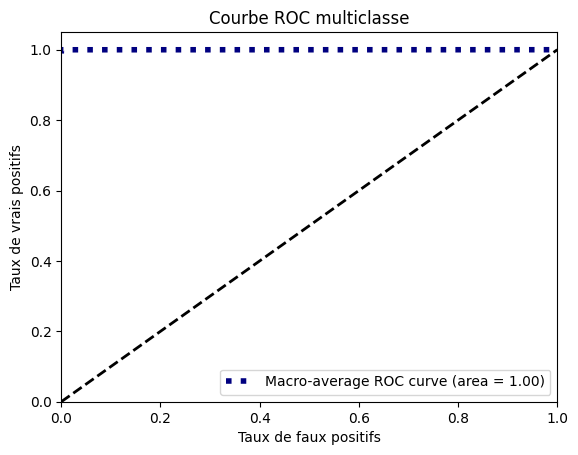

✅ Modèle enregistré avec succès à ../data/output/cluster_classifier.pkl ! 🚀
⏳ Temps total d'exécution : 46.81 secondes


In [14]:
# ⏳ Début du script
start_time = time.time()

# 📥 Charger les données
file_path = "../data/output/user_clusters.parquet"
print("🚀 Chargement du fichier...")
df = pd.read_parquet(file_path)
print(f"✅ Fichier chargé ! {df.shape[0]} lignes, {df.shape[1]} colonnes")

# 🚀 Supprimer les colonnes inutiles (user_id si présent)
if "user_id" in df.columns:
    df.drop(columns=["user_id"], inplace=True)
    print("✅ Colonne 'user_id' supprimée !")

# 🔍 Supprimer les lignes avec des NaN dans 'Cluster'
df.dropna(subset=["Cluster"], inplace=True)
print(f"✅ {df.isna().sum().sum()} valeurs NaN restantes")

# 📅 Conversion de 'last_event_time' en timestamp
print("🕒 Conversion de 'last_event_time' en timestamp...")
df['last_event_time'] = pd.to_datetime(df['last_event_time']).astype(int) / 10**9
print("✅ 'last_event_time' converti en timestamp !")

# 🎯 Séparation des features et du target
y = df["Cluster"]
X = df.drop(columns=["Cluster"])
print(f"📊 X shape: {X.shape}, y shape: {y.shape}")

# 🏎️ Échantillonnage avant SMOTE (optionnel si dataset très grand)
SAMPLE_SIZE = 500_000  # Ajuster selon la mémoire dispo
if len(X) > SAMPLE_SIZE:
    print(f"🔍 Échantillonnage aléatoire de {SAMPLE_SIZE} lignes...")
    df_sampled = df.sample(n=SAMPLE_SIZE, random_state=42)
    X, y = df_sampled.drop(columns=["Cluster"]), df_sampled["Cluster"]
    print("✅ Échantillonnage effectué !")

# ⚖️ Équilibrage du dataset avec SMOTE
print("⚖️ Application de SMOTE pour équilibrer les classes...")
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("✅ Répartition des classes après SMOTE :")
print(pd.Series(y_resampled).value_counts())

# 🧪 Division en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)
print("✅ Jeu d'entraînement et de test créés !")

# ⚖️ Calcul des poids de classe
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# ⚙️ Pipeline : Standardisation + XGBoost
print("⚙️ Création du pipeline...")
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                                  random_state=42, scale_pos_weight=class_weights))
])
print("✅ Pipeline prêt !")

# 🔍 Validation croisée
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"📊 Validation croisée Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

# 🎯 Entraînement du modèle
print("🚀 Entraînement du modèle...")
pipeline.fit(X_train, y_train)
print("✅ Modèle entraîné !")

# 📊 Prédiction et évaluation
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy : {accuracy:.4f}")
print("📊 Rapport de classification :\n", classification_report(y_test, y_pred))

# 💡 Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("📊 Matrice de confusion :\n", conf_matrix)

# 📈 Courbe ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_proba = pipeline.predict_proba(X_test)
n_classes = y_test_bin.shape[1]
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"📊 AUC macro : {roc_auc['macro']:.4f}")

plt.figure()
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC multiclasse')
plt.legend(loc="lower right")
plt.show()

# 💾 Sauvegarde du modèle
model_path = "../data/output/cluster_classifier.pkl"
joblib.dump(pipeline, model_path)
print(f"✅ Modèle enregistré avec succès à {model_path} ! 🚀")

# ⏳ Fin du script
end_time = time.time()
print(f"⏳ Temps total d'exécution : {end_time - start_time:.2f} secondes")